In [1]:
source("~/smartas/pipeline/scripts/variablesAndFunctions.r")
library(tidyr)

stromaCorr <- lapply(cancerTypes, function(tumor){
    filename <- paste0("../data/switches/estimate/", tumor, "_ouptut_r_stroma.txt")
    read.delim(filename) %>%
        mutate(., Switch=row.names(.), Tumor=tumor, Origin="Stroma") %>%
        separate(Switch,into=c("Normal_transcript","Tumor_transcript"), sep="-")
}) %>% do.call("rbind", .)

immuneCorr <- lapply(cancerTypes, function(tumor){
    filename <- paste0("../data/switches/estimate/", tumor, "_ouptut_r_immune.txt")
    read.delim(filename) %>%
        mutate(., Switch=row.names(.), Tumor=tumor, Origin="Immune") %>%
        separate(Switch,into=c("Normal_transcript","Tumor_transcript"), sep="-")
}) %>% do.call("rbind", .)

contaminantSwitches <- rbind(stromaCorr[,c("Normal_transcript","Tumor_transcript","Origin")],
                             immuneCorr[,c("Normal_transcript","Tumor_transcript","Origin")])

cellSpecificGenes <- read_tsv("../data/switches/estimate/geneset_ESTIMATE.txt", col_names = FALSE) %>% 
    t %>%
    as.data.frame %>%
    set_colnames(c("StromalSignature","ImmuneSignature")) %>%
    .[3:nrow(.),]

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(NotNoise==1 & IsModel==1) %>%
    left_join(contaminantSwitches) %>%
    mutate(Origin = ifelse(is.na(Origin),"Tumor",Origin))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract

The following object is masked from ‘package:reshape2’:

    smiths

Joining by: c("Normal_transcript", "Tumor_transcript")


# Stoma/immune associated switches

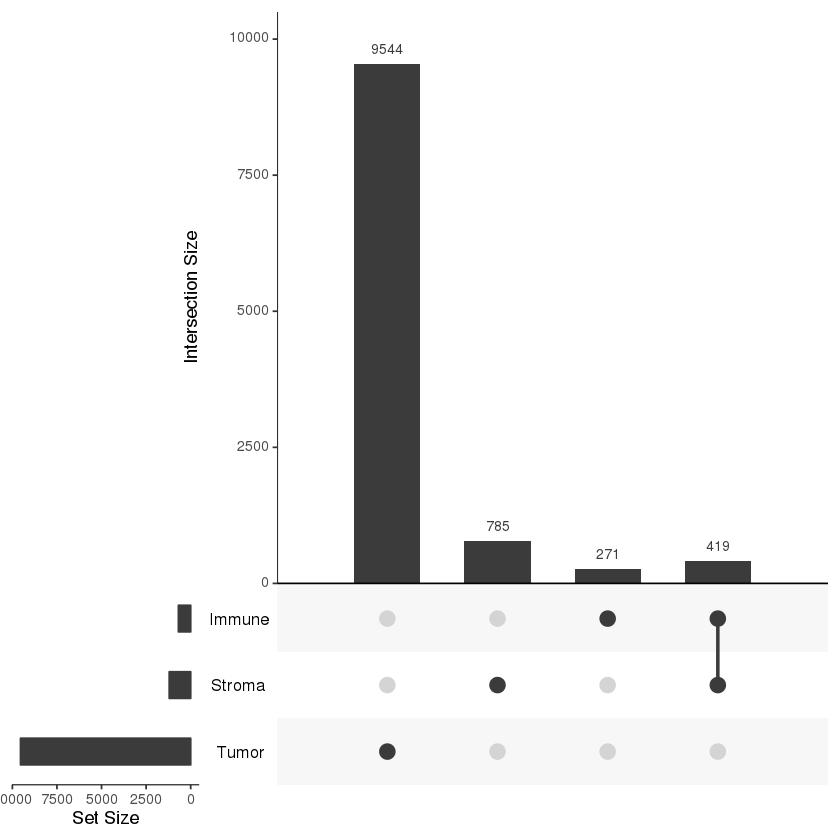

In [2]:
library(UpSetR)

switches %>%
    group_by(Normal_transcript,Tumor_transcript) %>%
    summarise(Origin=paste0(Origin, collapse="&")) %>%
    .$Origin %>%
    table %>%
    fromExpression(.) %>%
    upset

We cannot link an artifactual origin to most of the switches.

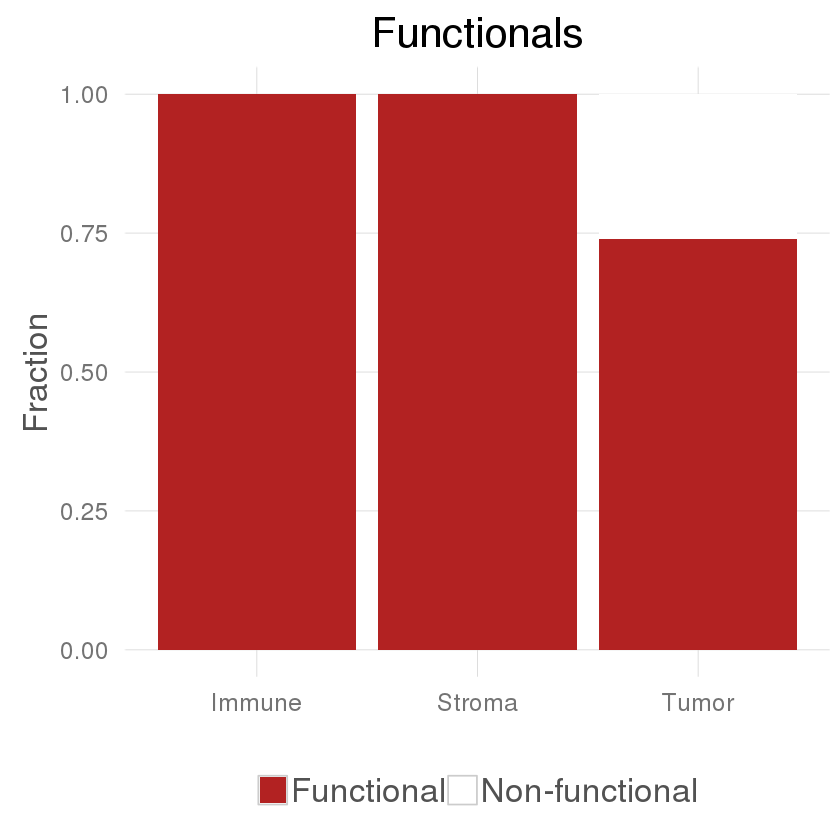

In [3]:
ggplot(switches, aes(x=Origin, fill=ifelse(IsFunctional==1, "Functional", "Non-functional"))) +
    geom_bar(position="fill") +
    labs(x="", y="Fraction", fill="", title="Functionals") +
    smartas_theme() +
    theme(legend.position="bottom") +
    scale_fill_manual(values = c("Functional"="firebrick", "Non-functional"="white"))

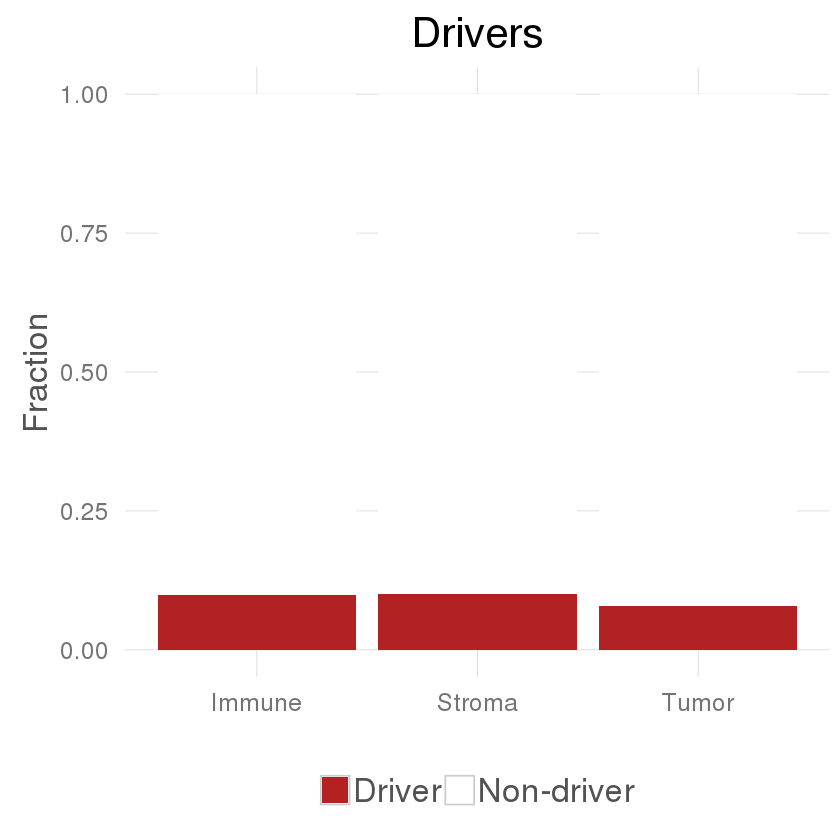

In [4]:
ggplot(switches, aes(x=Origin, fill=ifelse(Driver==1, "Driver", "Non-driver"))) +
    geom_bar(position="fill") +
    labs(x="", y="Fraction" , fill="", title="Drivers") +
    smartas_theme() +
    theme(legend.position="bottom") +
    scale_fill_manual(values = c("Driver"="firebrick", "Non-driver"="white"))

The proportion of drivers affected are similar across categories, albeit unexpectedly lower in Tumor switches.

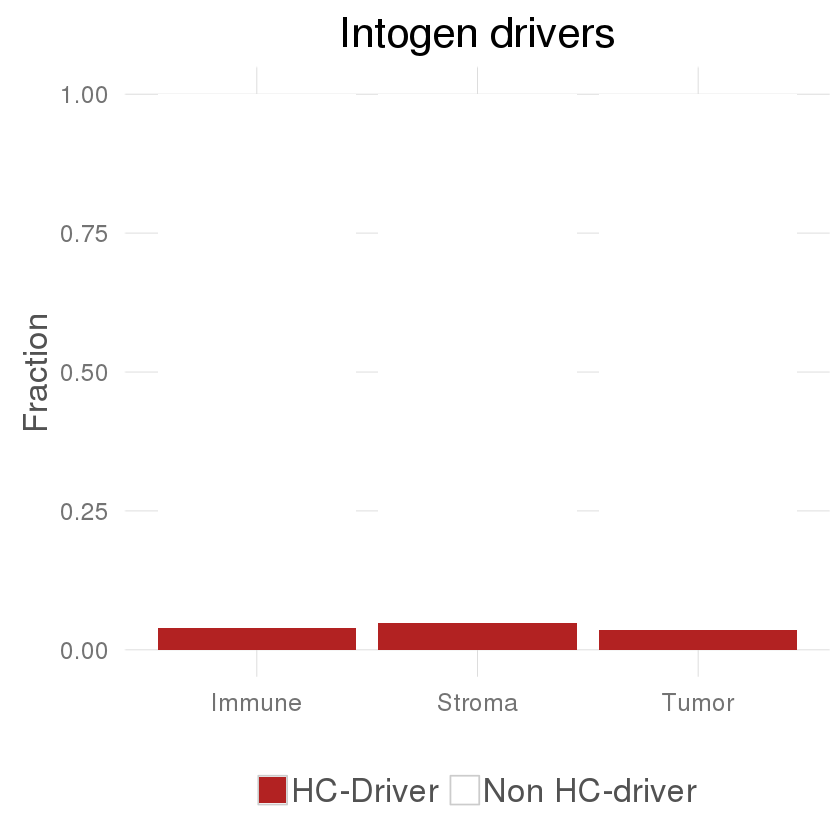

In [5]:
drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  set_colnames(c("Symbol","Tumor"))

ggplot(switches, aes(x=Origin, fill=ifelse(Symbol %in% drivers$Symbol, "HC-Driver", "Non HC-driver"))) +
    geom_bar(position="fill") +
    labs(x="", y="Fraction" , fill="", title="Intogen drivers") +
    smartas_theme() +
    theme(legend.position="bottom") +
    scale_fill_manual(values = c("HC-Driver"="firebrick", "Non HC-driver"="white"))

Still, the proportion of high-confidence drivers is pretty similar across categories.

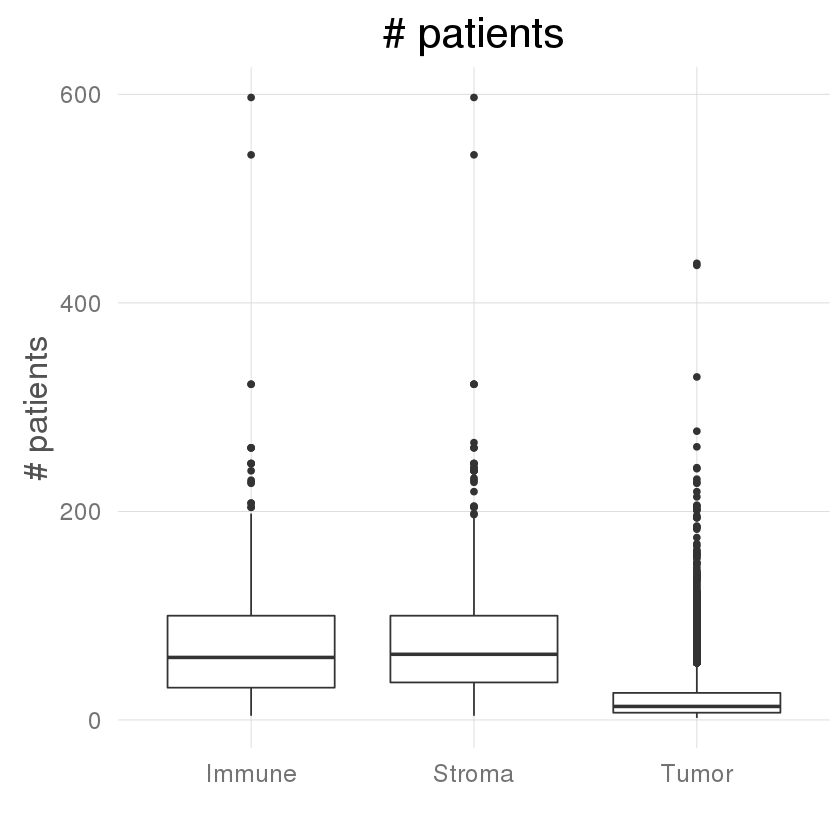

In [6]:
ggplot(switches, aes(x=Origin, y=PatientNumber)) +
    geom_boxplot() +
    labs(x="", y="# patients", title="# patients") +
    smartas_theme()

Tumor switches occur in less patients. This is not surprising, as the Immune/stroma is common to many patients, but tumors are patient-specific.

# Specific genes

In [7]:
# stroma-specific genes
switches %>%
    filter(Symbol %in% cellSpecificGenes$StromalSignature) %>%
    .$Origin %>%
    table

# stroma-specific genes
switches %>%
    filter(Symbol %in% cellSpecificGenes$ImmuneSignature) %>%
    .$Origin %>%
    table

.
Immune Stroma  Tumor 
    11     25     68 

.
Immune Stroma  Tumor 
    13     14     74 

Interestingly, most of the stroma/immune specific genes do not show a correlation with the presence of stroma/immune cells, respectively.